In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from skimage import io
from skimage import color
import os
import glob
from matplotlib import pyplot as plt
import pylab
%matplotlib inline

Read in training data with labels and the test set. The `masks` which contain the label infomration are transformed to ones and zeros, to get a binary problem for each pixel. These reduces the prediction space and will make the task easier, considering that only a tiny data set is given for training the network.
The 4th dimension of the inputs is discared because a pretrained network (VGG16) is used which expects images with 3 dimensions.

In [2]:
img_paths = glob.glob(os.path.join('./images/', '*.png'))
imgs = []
img_name = []
masks = []
mask_name = []
test_imgs = []
for img_path in img_paths:
    img = color.rgba2rgb(io.imread(img_path))
    
    mask_path = img_path.replace('images', 'labels')
    if os.path.exists(mask_path):
       img_name.append(img_path) 
       imgs.append(img) 
       mask = io.imread(mask_path)       
       mask_name.append(mask_path)
       mask[mask<=128] = 0
       mask[mask>128] = 1 
       masks.append(mask[:,:,np.newaxis])
    else:
       test_imgs.append(img)
       
    

Check order of images and labels:

In [3]:
for (pic, label) in zip(img_name, mask_name):
    print(pic, label)

./images/417.png ./labels/417.png
./images/317.png ./labels/317.png
./images/303.png ./labels/303.png
./images/328.png ./labels/328.png
./images/300.png ./labels/300.png
./images/314.png ./labels/314.png
./images/274.png ./labels/274.png
./images/315.png ./labels/315.png
./images/301.png ./labels/301.png
./images/270.png ./labels/270.png
./images/272.png ./labels/272.png
./images/121.png ./labels/121.png
./images/337.png ./labels/337.png
./images/241.png ./labels/241.png
./images/532.png ./labels/532.png
./images/320.png ./labels/320.png
./images/308.png ./labels/308.png
./images/324.png ./labels/324.png
./images/278.png ./labels/278.png
./images/287.png ./labels/287.png
./images/284.png ./labels/284.png
./images/381.png ./labels/381.png
./images/343.png ./labels/343.png
./images/379.png ./labels/379.png
./images/345.png ./labels/345.png


In [4]:
for (pic, mask) in zip(imgs, masks):
    print(pic.shape, mask.shape)

(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)
(256, 256, 3) (256, 256, 1)


Here a pretrained network (VGG16) is used. The last layer is removed and addition layers are added for our specific task. Using the lower layers of a network with was trained on a bigger dataset, is expected to provide useful features that help for our prediction task. But only the lower convolutional layers of the VGG16 are used because for detecting roofs only edges and combined edges seem important, not the complexer features of higher layers.
The weights of original VGG16 are not updated, only the added layers are updated during training. 
The last layer is reshaped to the size of the label mask. For each pixel of the mask a value is predicted with the sigmoid function. As training objective the logloss is chosen.

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.layers.core import Reshape
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input	
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

def adjusted_Vgg(X):
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X.shape[1:], classes=1)
    parallel_input = AveragePooling2D(pool_size=(5, 5), strides=None, padding='valid', data_format=None)(base_model.input)
    parallel_input = Flatten()(parallel_input)
    x = base_model.get_layer('block2_pool').output 
    x = GlobalMaxPooling2D()(x)
    merge_one = concatenate([x, parallel_input])
    merge_one = Dense(256*256, activation='relu', name='fc1')(merge_one)
    merge_one = Dropout(0.2)(merge_one)
    merge_one = Reshape((256, 256, 1))(merge_one)
    predictions = Activation('sigmoid')(merge_one)
    model = Model(input=[base_model.input], output=predictions)
    for idx,layer in enumerate(model.layers[:-5]):
        layer.trainable = False    
    for idx,layer in enumerate(model.layers):
        print(layer, layer.trainable)    
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

imgs = np.asarray(imgs)[:25,:,:,:]
masks = np.asarray(masks)
test_imgs = np.asarray(test_imgs)

# we create two instances with the same arguments for data augmentation
data_gen_args = dict(horizontal_flip = True,
                     vertical_flip = True,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     rotation_range=90.,
                     zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods to  guarantee same
# transformations for images and masks
seed = 1
batch_size = 2
image_datagen.fit(imgs, augment=True, seed=seed)
mask_datagen.fit(masks, augment=True, seed=seed)


# Finally create generator
def get_callbacks(filepath, patience=2):
   es = EarlyStopping('val_loss', patience=patience, mode="min")
   msave = ModelCheckpoint(filepath, save_best_only=True)
   return [es, msave]

def visualize_predictions(predictions, images):
    for i in range(predictions.shape[0]):
            fig = plt.figure(figsize=(24, 24))
            fig.add_subplot(predictions.shape[0], 2,2*i+1)
            plt.imshow(predictions[i].squeeze(), interpolation=None, cmap='Greys')
            fig.add_subplot(predictions.shape[0],2,2*i+2)
            plt.imshow(images[i], interpolation=None)
    plt.show()

# #Using K-fold Cross Validation with Data Augmentation.
def adjusted_VGG_CV(X_train, target_train, X_test):
    K=5
    folds = list(KFold(n_splits=K, shuffle=True, random_state=36).split(X_train, target_train))
    y_test_preds = 0
    for j, (train_idx, test_idx) in enumerate(folds):
        print('\n===============FOLD=',j, ' =====================')
        X_train_cv = X_train[train_idx]
        y_train_cv = target_train[train_idx]
        X_holdout = X_train[test_idx]
        y_holdout= target_train[test_idx]
     
        image_generator = image_datagen.flow(X_train_cv, seed=seed, batch_size=batch_size)
        mask_generator = mask_datagen.flow(y_train_cv, seed=seed, batch_size=batch_size)
        # combine generators into one which yields image and masks
        train_generator = zip(image_generator, mask_generator)
        file_path = "%s_aug_model_weights.hdf5"%j
        callbacks = get_callbacks(filepath=file_path, patience=5)
        model = adjusted_Vgg(imgs)

        model.fit_generator(
            train_generator,
            steps_per_epoch=10,
            epochs=50,
        verbose=1,
        shuffle=True,
        validation_data=([X_holdout], y_holdout),
                callbacks=callbacks)
        # getting weights of the best model on validation data
        model.load_weights(filepath=file_path)
        # calculate training Score
        score = model.evaluate([X_train_cv], y_train_cv, verbose=0)
        print('train loss:', score[0])
        print('train accuracy:', score[1])
        # calculate the validation score
        score = model.evaluate([X_holdout], y_holdout, verbose=0)
        print('validation loss:', score[0])
        print('validation accuracy:', score[1])
        pred_valid=model.predict([X_holdout])
        visualize_predictions(pred_valid, X_holdout)
        # predicting on test set
        temp_test=model.predict([X_test])
        y_test_preds+=temp_test
    
    # average predictions on test data
    y_test_preds=y_test_preds/K
    return y_test_preds





===============FOLD= 0  =====================
(?, 51, 51, 3)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
(?, 64)
<keras.engine.topology.InputLayer object at 0x113f17e10> False
<keras.layers.convolutional.Conv2D object at 0x113f17908> False
<keras.layers.convolutional.Conv2D object at 0x115f08438> False
<keras.layers.pooling.MaxPooling2D object at 0x115f08978> False
<keras.layers.pooling.AveragePooling2D object at 0x1a1e7a13c8> False
<keras.layers.pooling.GlobalMaxPooling2D object at 0x1a1e7c1b00> False
<keras.layers.core.Flatten object at 0x1a1ed77780> False
<keras.layers.merge.Concatenate object at 0x1a1e7d1780> True
<keras.layers.core.Dense object at 0x1a1ed81d68> True
<keras.layers.core.Dropout object at 0x1a20e03c18> True
<keras.layers.core.Reshape object at 0x1a1eda1438> True
<keras.layers.core.Activation object at 0x1a1edb1e10> True
Instructions for updating:
keep_dims is deprec

/Users/sage/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:39: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


Epoch 1/50
10/10 [==============================] - 67s 7s/step - loss: 0.7793 - acc: 0.5762 - val_loss: 0.7672 - val_acc: 0.5096
Epoch 2/50
10/10 [==============================] - 53s 5s/step - loss: 0.7685 - acc: 0.5842 - val_loss: 0.7576 - val_acc: 0.5243
Epoch 3/50
10/10 [==============================] - 51s 5s/step - loss: 0.7585 - acc: 0.5984 - val_loss: 0.7474 - val_acc: 0.5436
Epoch 4/50
10/10 [==============================] - 51s 5s/step - loss: 0.7479 - acc: 0.6154 - val_loss: 0.7379 - val_acc: 0.5660
Epoch 5/50
10/10 [==============================] - 52s 5s/step - loss: 0.7377 - acc: 0.6326 - val_loss: 0.7295 - val_acc: 0.5913
Epoch 6/50
10/10 [==============================] - 55s 5s/step - loss: 0.7287 - acc: 0.6521 - val_loss: 0.7223 - val_acc: 0.6158
Epoch 7/50
10/10 [==============================] - 53s 5s/step - loss: 0.7229 - acc: 0.6734 - val_loss: 0.7164 - val_acc: 0.6397
Epoch 8/50
10/10 [==============================] - 52s 5s/step - loss: 0.7165 - acc: 0.69

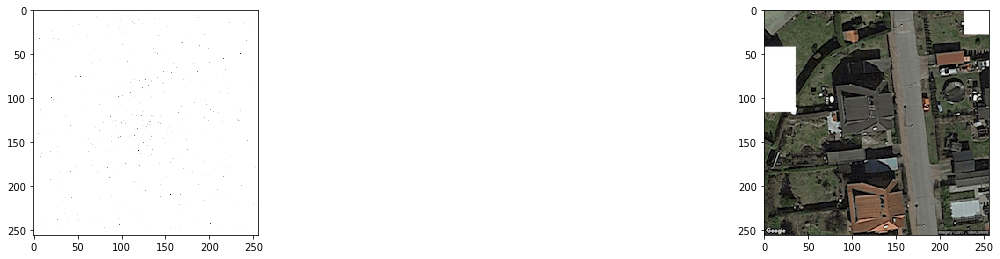

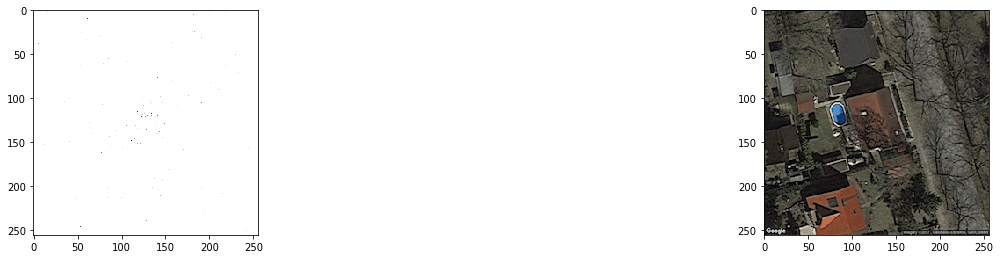

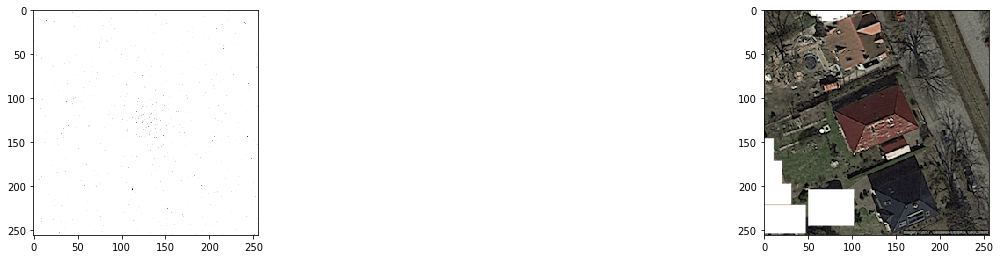

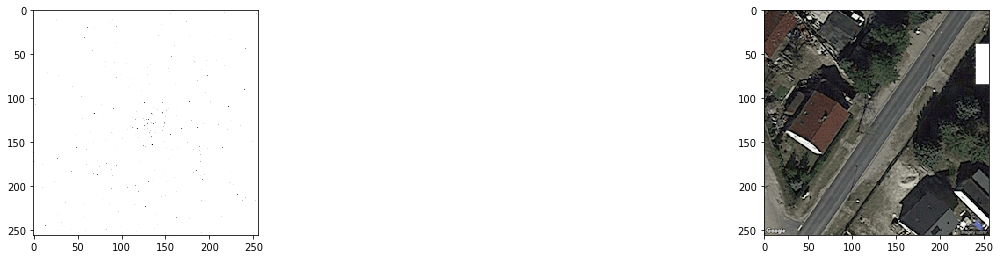

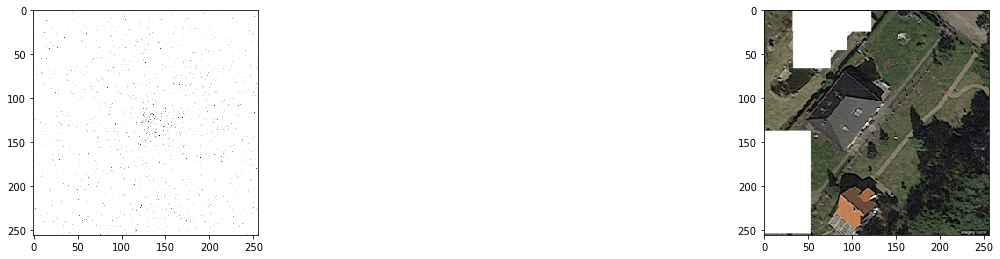


===============FOLD= 1  =====================
(?, 51, 51, 3)
(?, 64)
<keras.engine.topology.InputLayer object at 0x113f175c0> False
<keras.layers.convolutional.Conv2D object at 0x10d75d0b8> False
<keras.layers.convolutional.Conv2D object at 0x10d75d400> False
<keras.layers.pooling.MaxPooling2D object at 0x1a218637b8> False
<keras.layers.pooling.AveragePooling2D object at 0x1a358b8f60> False
<keras.layers.pooling.GlobalMaxPooling2D object at 0x1a2214a828> False
<keras.layers.core.Flatten object at 0x1a1e843c50> False
<keras.layers.merge.Concatenate object at 0x1a34b78ac8> True
<keras.layers.core.Dense object at 0x1a358cdf60> True
<keras.layers.core.Dropout object at 0x1a358eb080> True
<keras.layers.core.Reshape object at 0x10d692b00> True
<keras.layers.core.Activation object at 0x1a381b3c88> True
Epoch 1/50
10/10 [==============================] - 106s 11s/step - loss: 0.7770 - acc: 0.5754 - val_loss: 0.7776 - val_acc: 0.5088
Epoch 2/50
10/10 [==============================] - 81s 8s/s

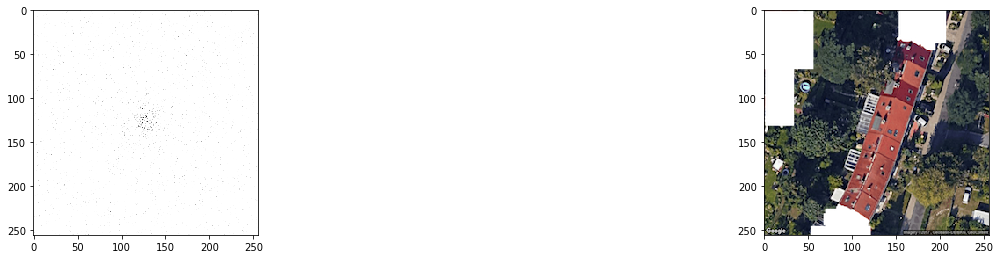

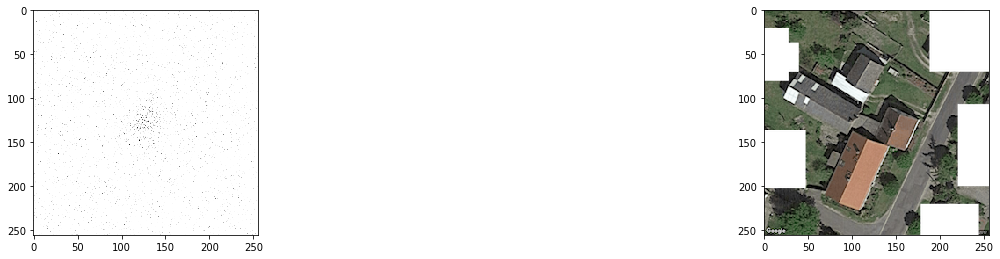

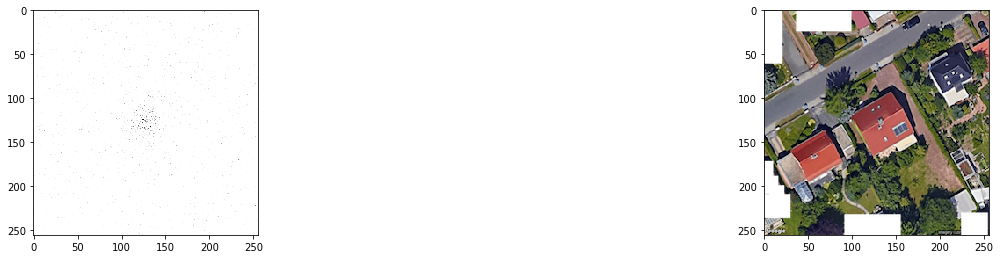

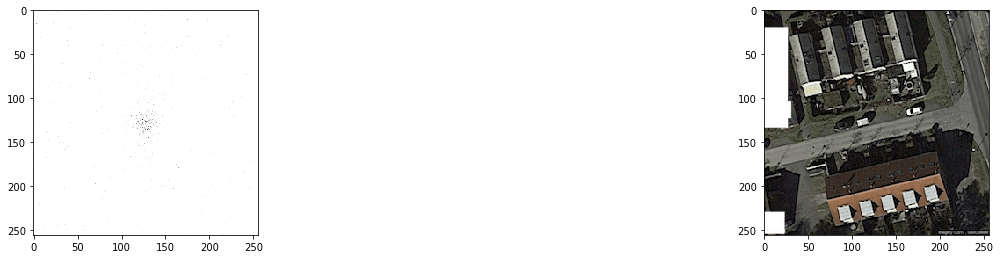

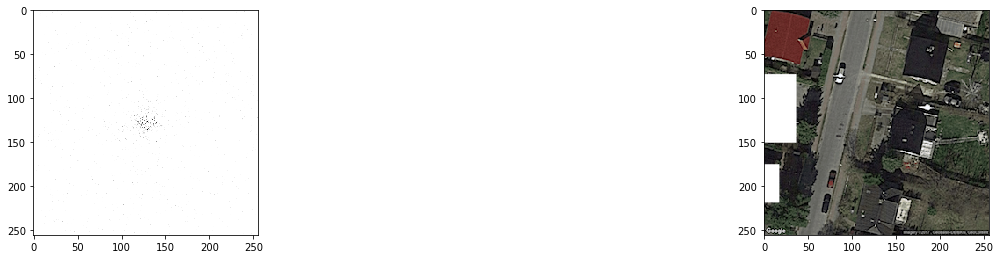


===============FOLD= 2  =====================
(?, 51, 51, 3)
(?, 64)
<keras.engine.topology.InputLayer object at 0x113e89ac8> False
<keras.layers.convolutional.Conv2D object at 0x1a321244a8> False
<keras.layers.convolutional.Conv2D object at 0x1a1fcbe6a0> False
<keras.layers.pooling.MaxPooling2D object at 0x1a320fb2b0> False
<keras.layers.pooling.AveragePooling2D object at 0x1a1e8f6898> False
<keras.layers.pooling.GlobalMaxPooling2D object at 0x1a216edef0> False
<keras.layers.core.Flatten object at 0x1a2181c278> False
<keras.layers.merge.Concatenate object at 0x1a1fc98fd0> True
<keras.layers.core.Dense object at 0x113ccaba8> True
<keras.layers.core.Dropout object at 0x1a1e8e1908> True
<keras.layers.core.Reshape object at 0x1a1fc9cd30> True
<keras.layers.core.Activation object at 0x1a1e8f69b0> True
Epoch 1/50
10/10 [==============================] - 68s 7s/step - loss: 0.7790 - acc: 0.5760 - val_loss: 0.7685 - val_acc: 0.5083
Epoch 2/50
10/10 [==============================] - 46s 5s/s

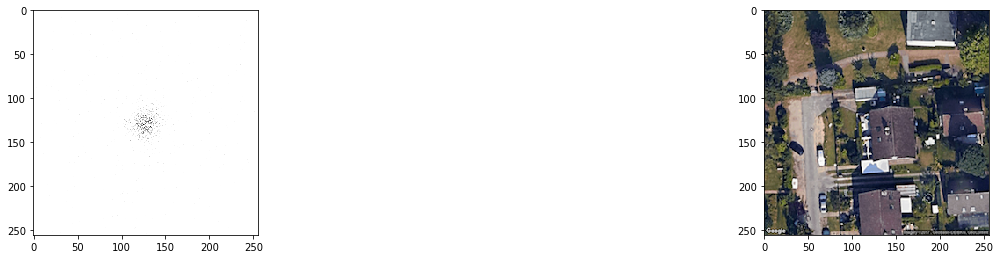

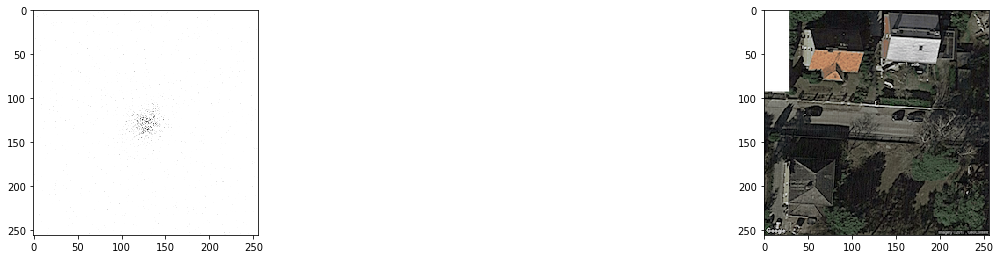

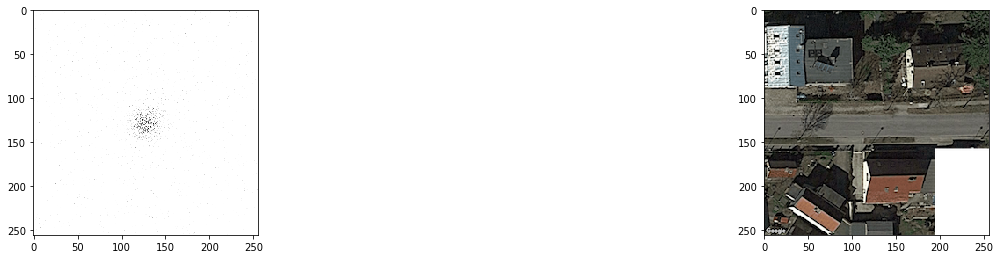

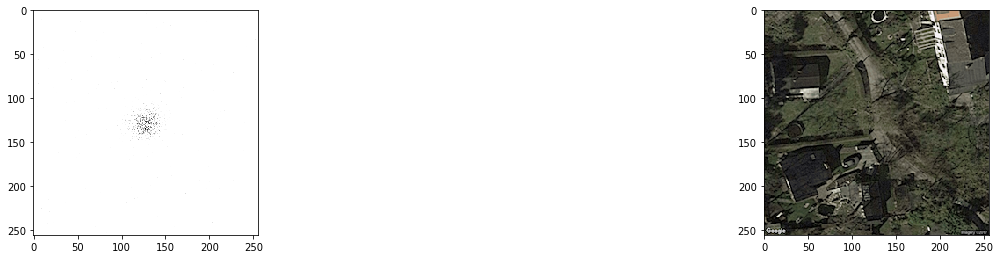

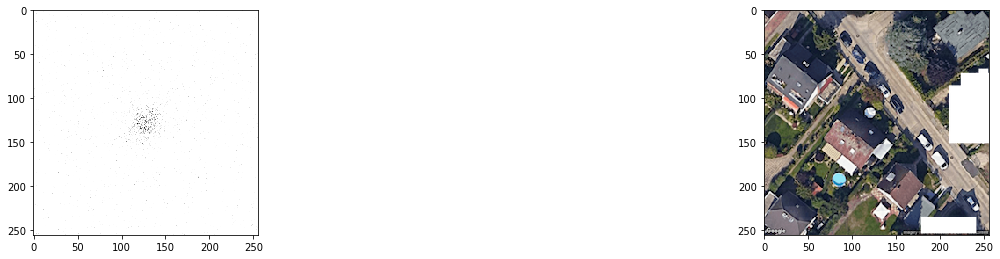


===============FOLD= 3  =====================
(?, 51, 51, 3)
(?, 64)
<keras.engine.topology.InputLayer object at 0x1a1fa832b0> False
<keras.layers.convolutional.Conv2D object at 0x1a1fe794e0> False
<keras.layers.convolutional.Conv2D object at 0x1a218d3b00> False
<keras.layers.pooling.MaxPooling2D object at 0x1a32020e80> False
<keras.layers.pooling.AveragePooling2D object at 0x1a31f7f3c8> False
<keras.layers.pooling.GlobalMaxPooling2D object at 0x1a31f66780> False
<keras.layers.core.Flatten object at 0x1a1e8cceb8> False
<keras.layers.merge.Concatenate object at 0x1a31f66470> True
<keras.layers.core.Dense object at 0x1a32100438> True
<keras.layers.core.Dropout object at 0x1a1faead30> True
<keras.layers.core.Reshape object at 0x1a1f062f28> True
<keras.layers.core.Activation object at 0x1a1e8b9080> True
Epoch 1/50
10/10 [==============================] - 103s 10s/step - loss: 0.7780 - acc: 0.5739 - val_loss: 0.7705 - val_acc: 0.5085
Epoch 2/50
10/10 [==============================] - 59s 

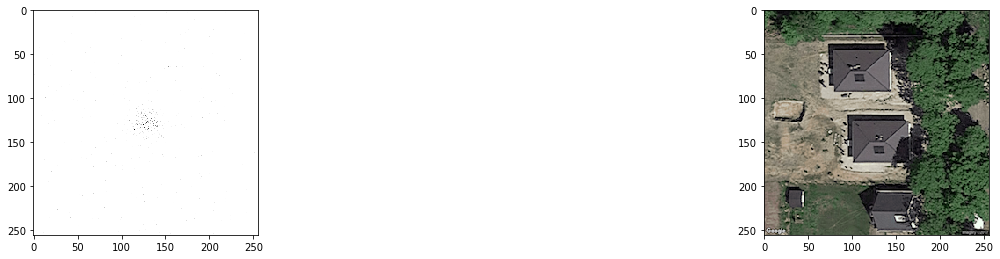

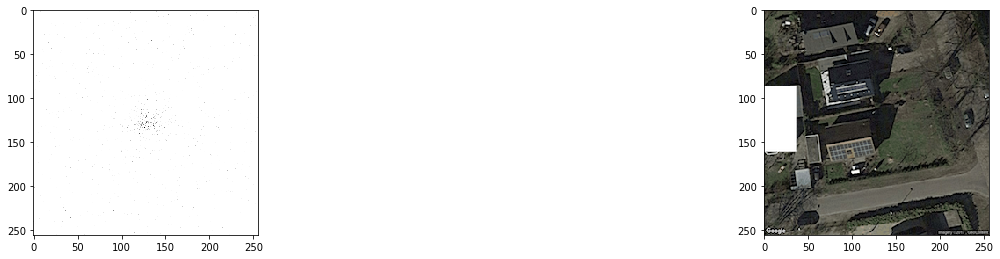

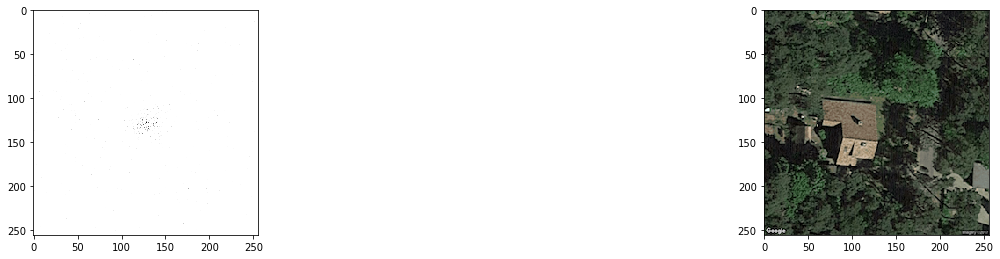

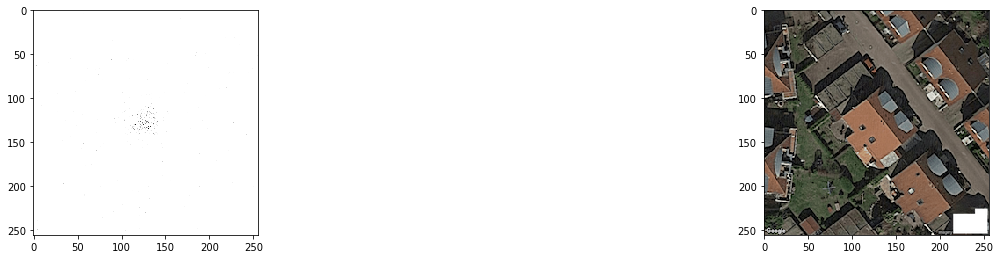

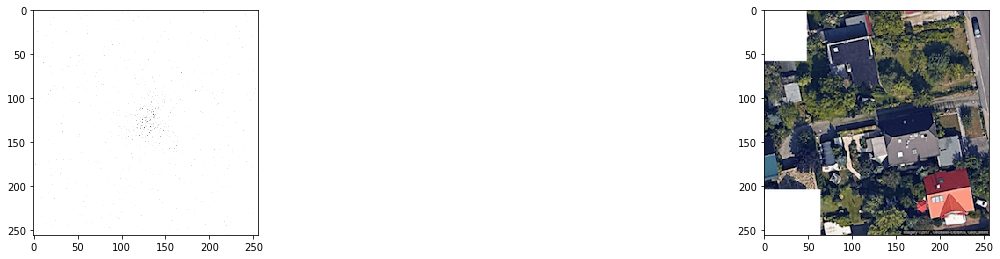


===============FOLD= 4  =====================
(?, 51, 51, 3)
(?, 64)
<keras.engine.topology.InputLayer object at 0x1a320047f0> False
<keras.layers.convolutional.Conv2D object at 0x1a35c91470> False
<keras.layers.convolutional.Conv2D object at 0x1a35c91400> False
<keras.layers.pooling.MaxPooling2D object at 0x1a35c74908> False
<keras.layers.pooling.AveragePooling2D object at 0x1a35c91e10> False
<keras.layers.pooling.GlobalMaxPooling2D object at 0x1a35c84c50> False
<keras.layers.core.Flatten object at 0x1a359f6828> False
<keras.layers.merge.Concatenate object at 0x1a35d80f28> True
<keras.layers.core.Dense object at 0x1a35d7dbe0> True
<keras.layers.core.Dropout object at 0x1a35f59898> True
<keras.layers.core.Reshape object at 0x1a1fbcbfd0> True
<keras.layers.core.Activation object at 0x1a1e8ccc50> True
Epoch 1/50
10/10 [==============================] - 97s 10s/step - loss: 0.7780 - acc: 0.5746 - val_loss: 0.7746 - val_acc: 0.5087
Epoch 2/50
10/10 [==============================] - 54s 5

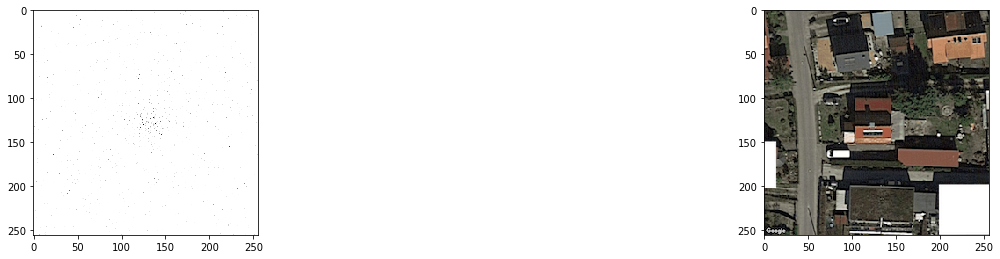

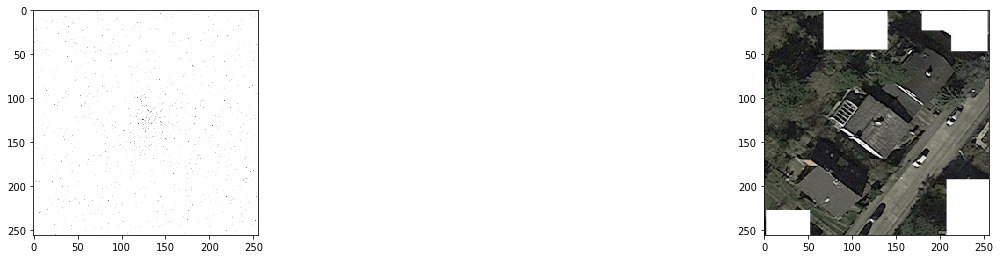

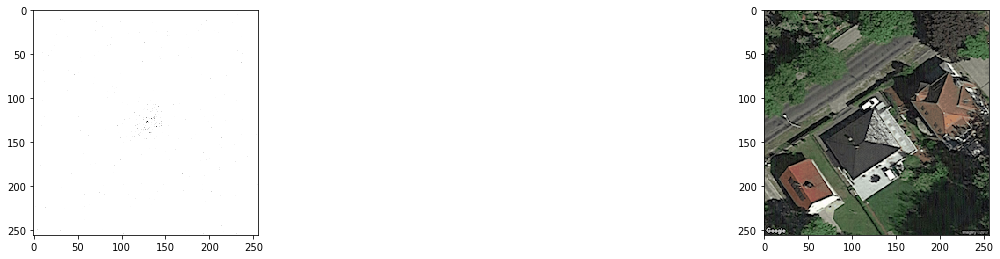

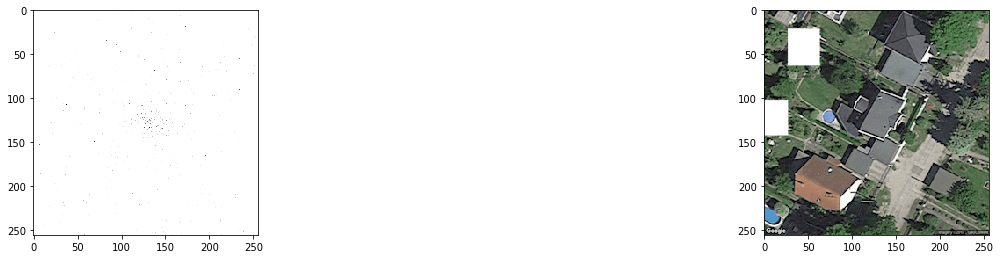

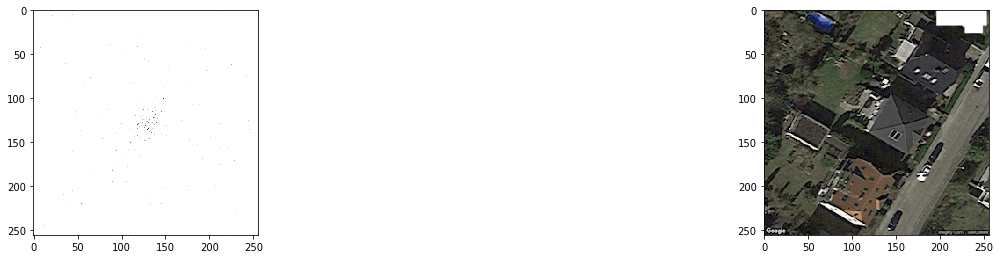

In [8]:
test_predictions = adjusted_VGG_CV(imgs, masks, test_imgs)

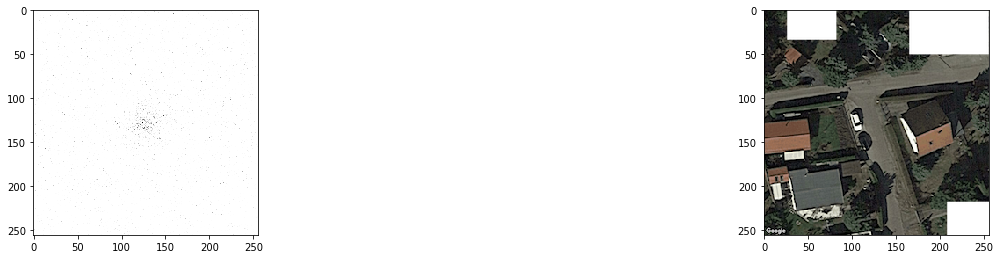

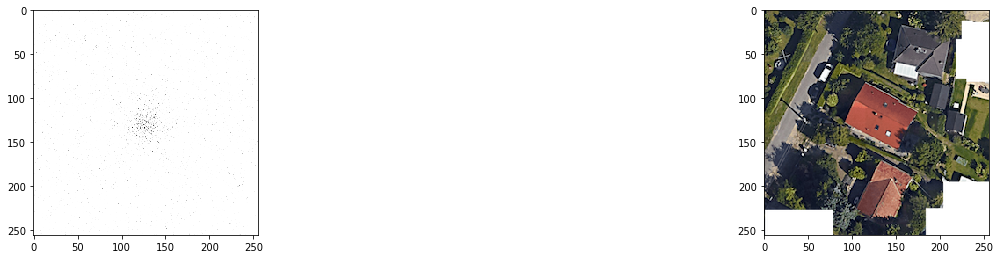

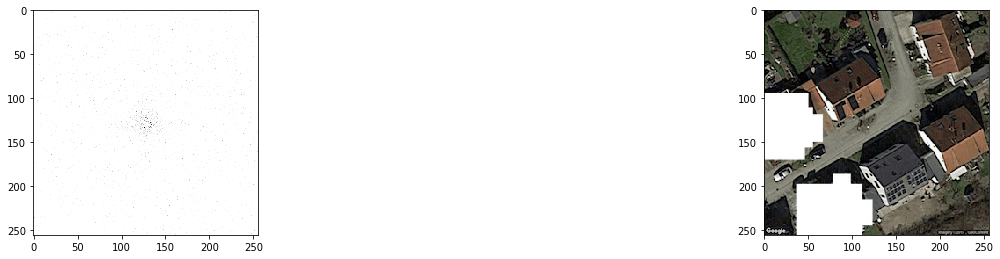

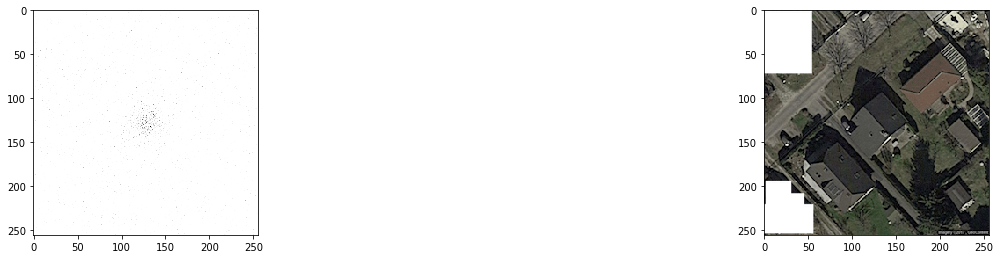

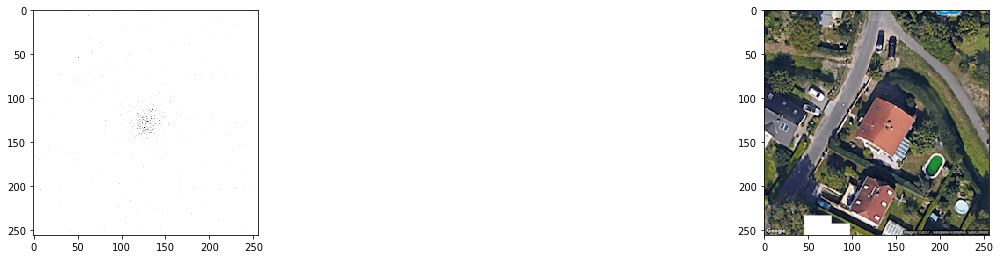

In [9]:
visualize_predictions(test_predictions, test_imgs)